In [2]:
import googlemaps
import networkx as nx
import numpy as np
import osmnx as ox
import folium
from IPython.display import Image
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
import geopandas as gpd

ox.config(log_console=True, use_cache=True)
ox.__version__

'0.12.1'

In [2]:
import matplotlib.pyplot as plt

In [3]:
elevation_key = 'elevation_key'

In [4]:
gmaps = googlemaps.Client(key=elevation_key)

In [5]:
place = 'Rome'
place_query = {'city':'Rome', 'country':'Italy'}
G = ox.graph_from_place(place_query, network_type='drive')

In [6]:
G = ox.add_node_elevations(G, api_key=elevation_key)
G = ox.add_edge_grades(G)

In [7]:
edge_grades = [data['grade_abs'] for u, v, k, data in ox.get_undirected(G).edges(keys=True, data=True)]

In [8]:
avg_grade = np.mean(edge_grades)
print('Average street grade in {} is {:.1f}%'.format(place, avg_grade*100))

med_grade = np.median(edge_grades)
print('Median street grade in {} is {:.1f}%'.format(place, med_grade*100))

Average street grade in Rome is 2.2%
Median street grade in Rome is 1.4%


In [9]:
G_proj = ox.project_graph(G)


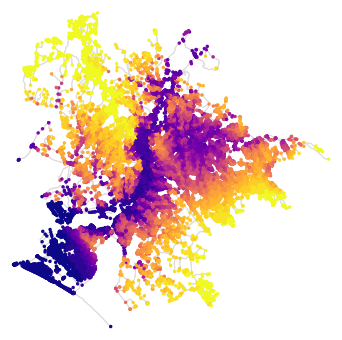

In [10]:
# get one color for each node, by elevation, then plot the network
nc = ox.get_node_colors_by_attr(G_proj, 'elevation', cmap='plasma', num_bins=20)
fig, ax = ox.plot_graph(G_proj, fig_height=6, node_color=nc, node_size=12, node_zorder=2, edge_color='#dddddd')


<Figure size 1440x720 with 0 Axes>

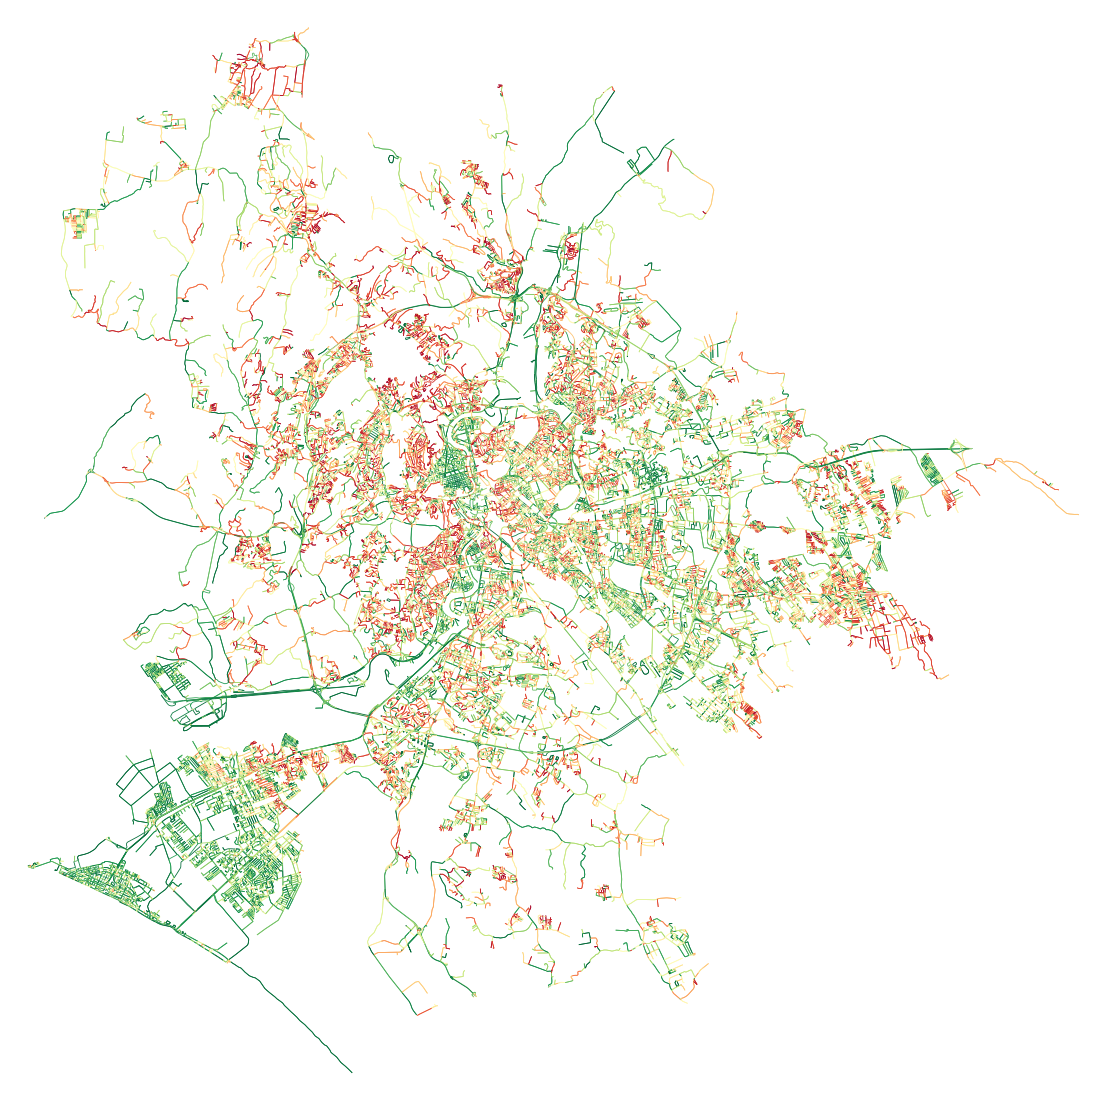

In [16]:
# get a color for each edge, by grade, then plot the network
ec = ox.get_edge_colors_by_attr(G_proj, 'grade_abs', cmap='RdYlGn_r', num_bins=100)
plt.figure(figsize=(20,10))
fig, ax = ox.plot_graph(G_proj, fig_height=20, edge_color=ec, edge_linewidth=0.8, node_size=0,
                       filename='mappa.png')


In [83]:
#graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)


ImportError: The folium package must be installed to use this optional feature.

In [72]:
img_folder = 'images'
extension = 'png'
size = 240
dpi = 120

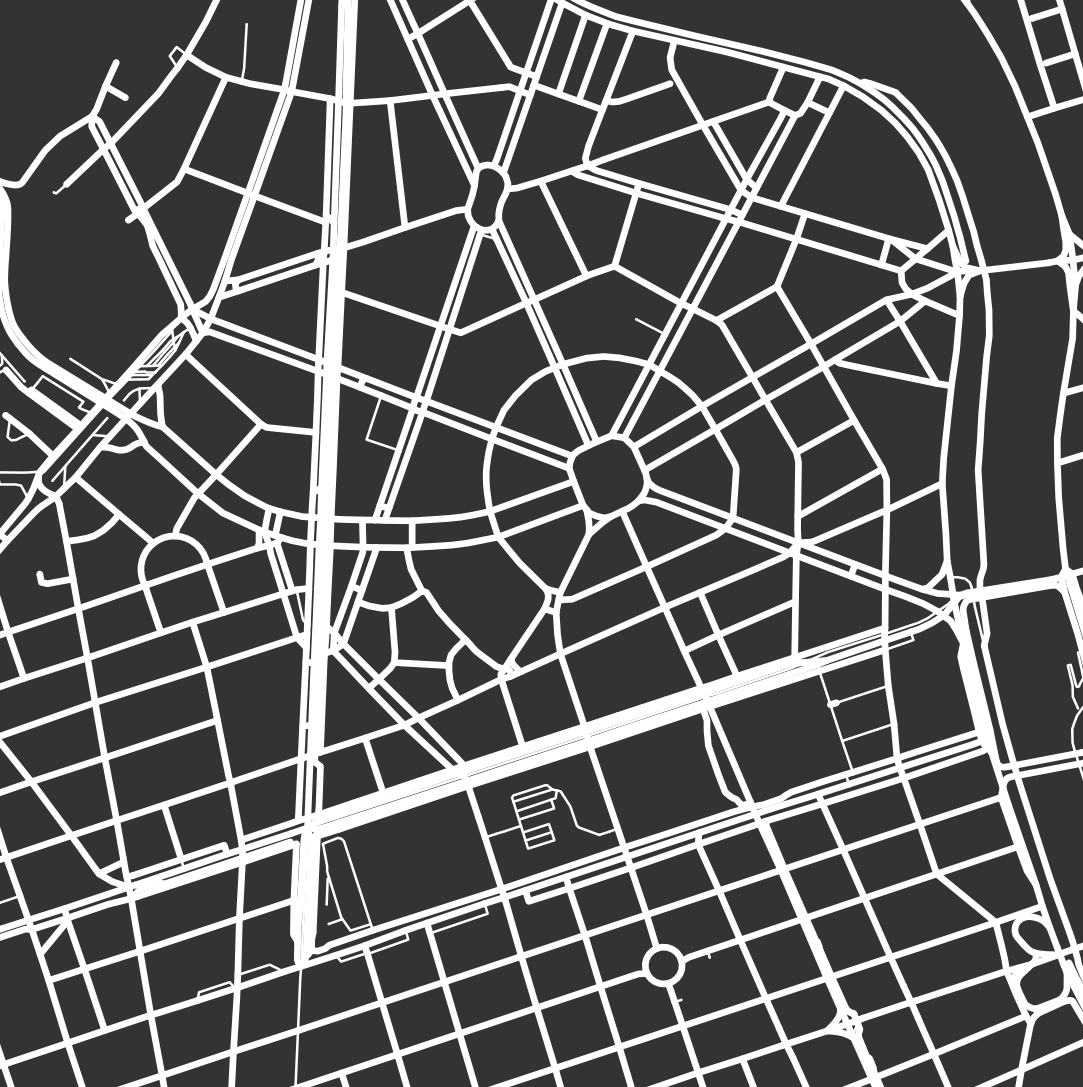

In [82]:
place = 'rome'
point = (41.9150, 12.4623)
fig, ax = ox.plot_figure_ground(point=point, filename=place, dpi=dpi, fig_length=12, network_type='bike')
Image('{}/{}.{}'.format(img_folder,place,extension), height=size, width=size)

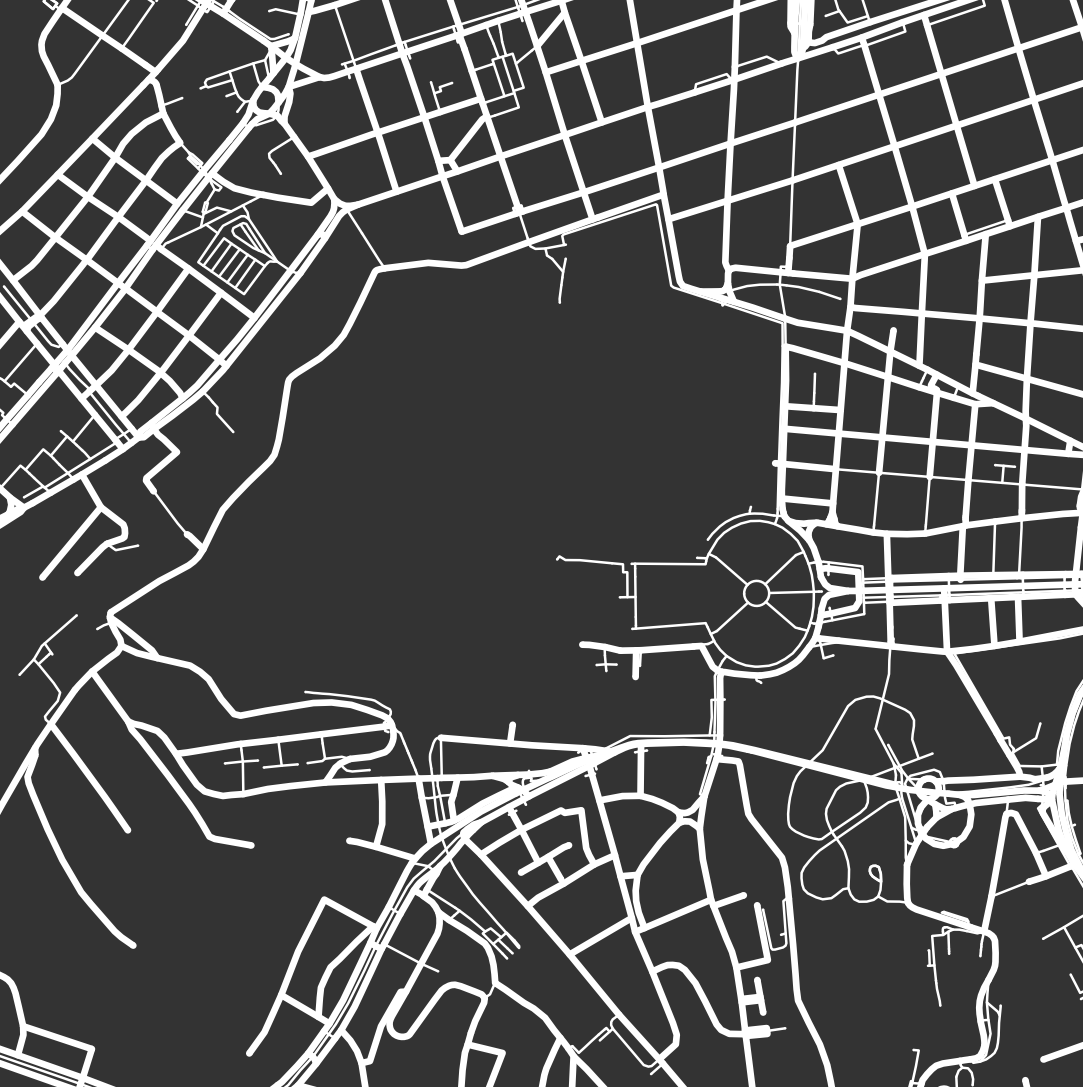

In [84]:
place = 'vatican'
point = (41.9029, 12.4534)
fig, ax = ox.plot_figure_ground(point=point, filename=place, dpi=dpi, fig_length=12, network_type='walk')
Image('{}/{}.{}'.format(img_folder,place,extension), height=size, width=size)

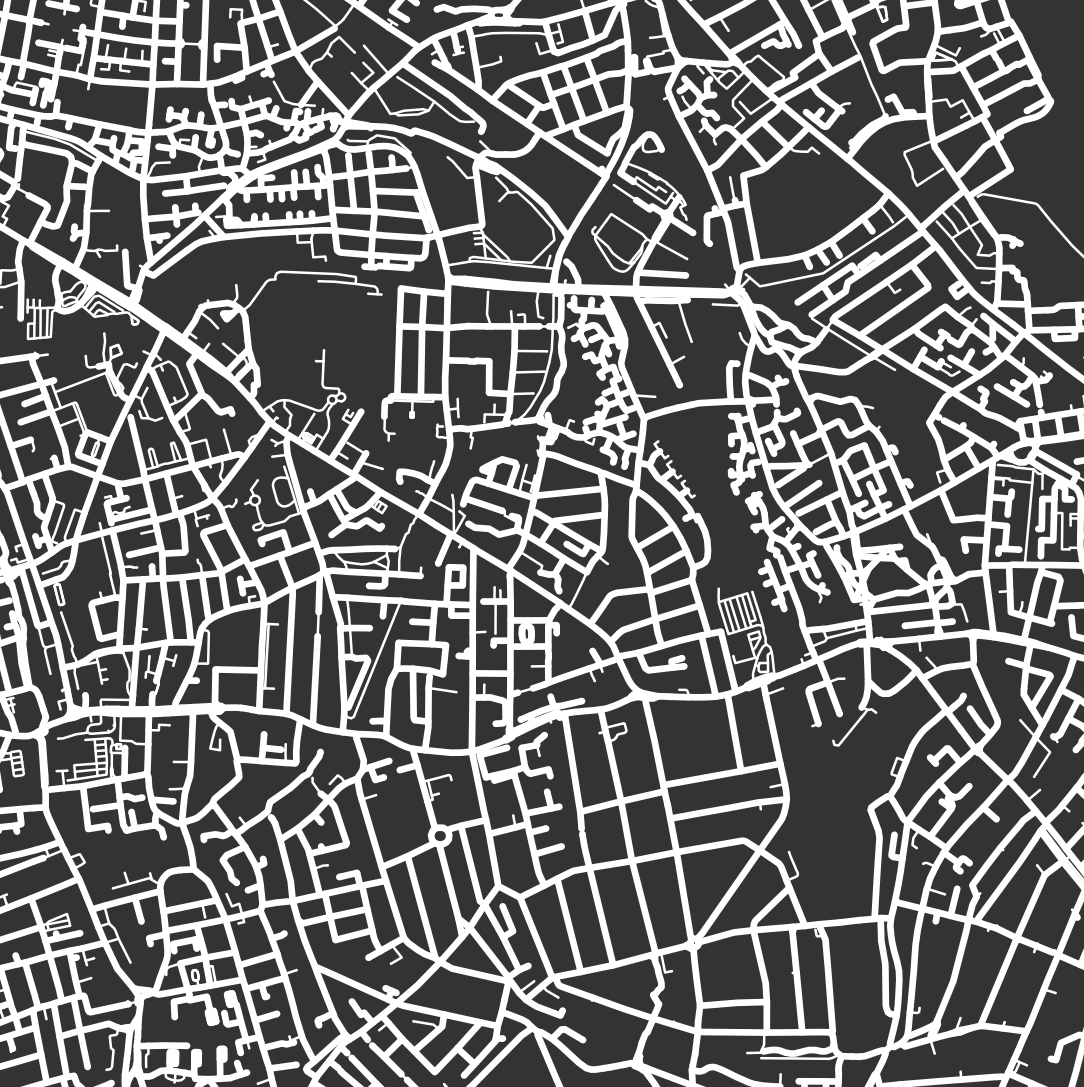

In [90]:
place = 'selnd'
point = (51.478122, -0.049931)
fig, ax = ox.plot_figure_ground(point=point, filename=place, dpi=dpi, fig_length=12, 
                                dist=1500,network_type='bike')
Image('{}/{}.{}'.format(img_folder,place,extension), height=size, width=size)

# Walking - Cycling IsoChrones

In [17]:
place = 'Rome, Italy'
network_type = 'walk'
trip_times = [5, 10, 15, 20, 25, 30, 35] #in minutes
travel_speed = 15 #walking speed in km/hour

In [4]:
G = ox.graph_from_place(place, network_type=network_type)


In [5]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

In [18]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [15]:
iso_colors = ox.get_colors(n=len(trip_times), cmap='Greens', start=0.3, return_hex=True)


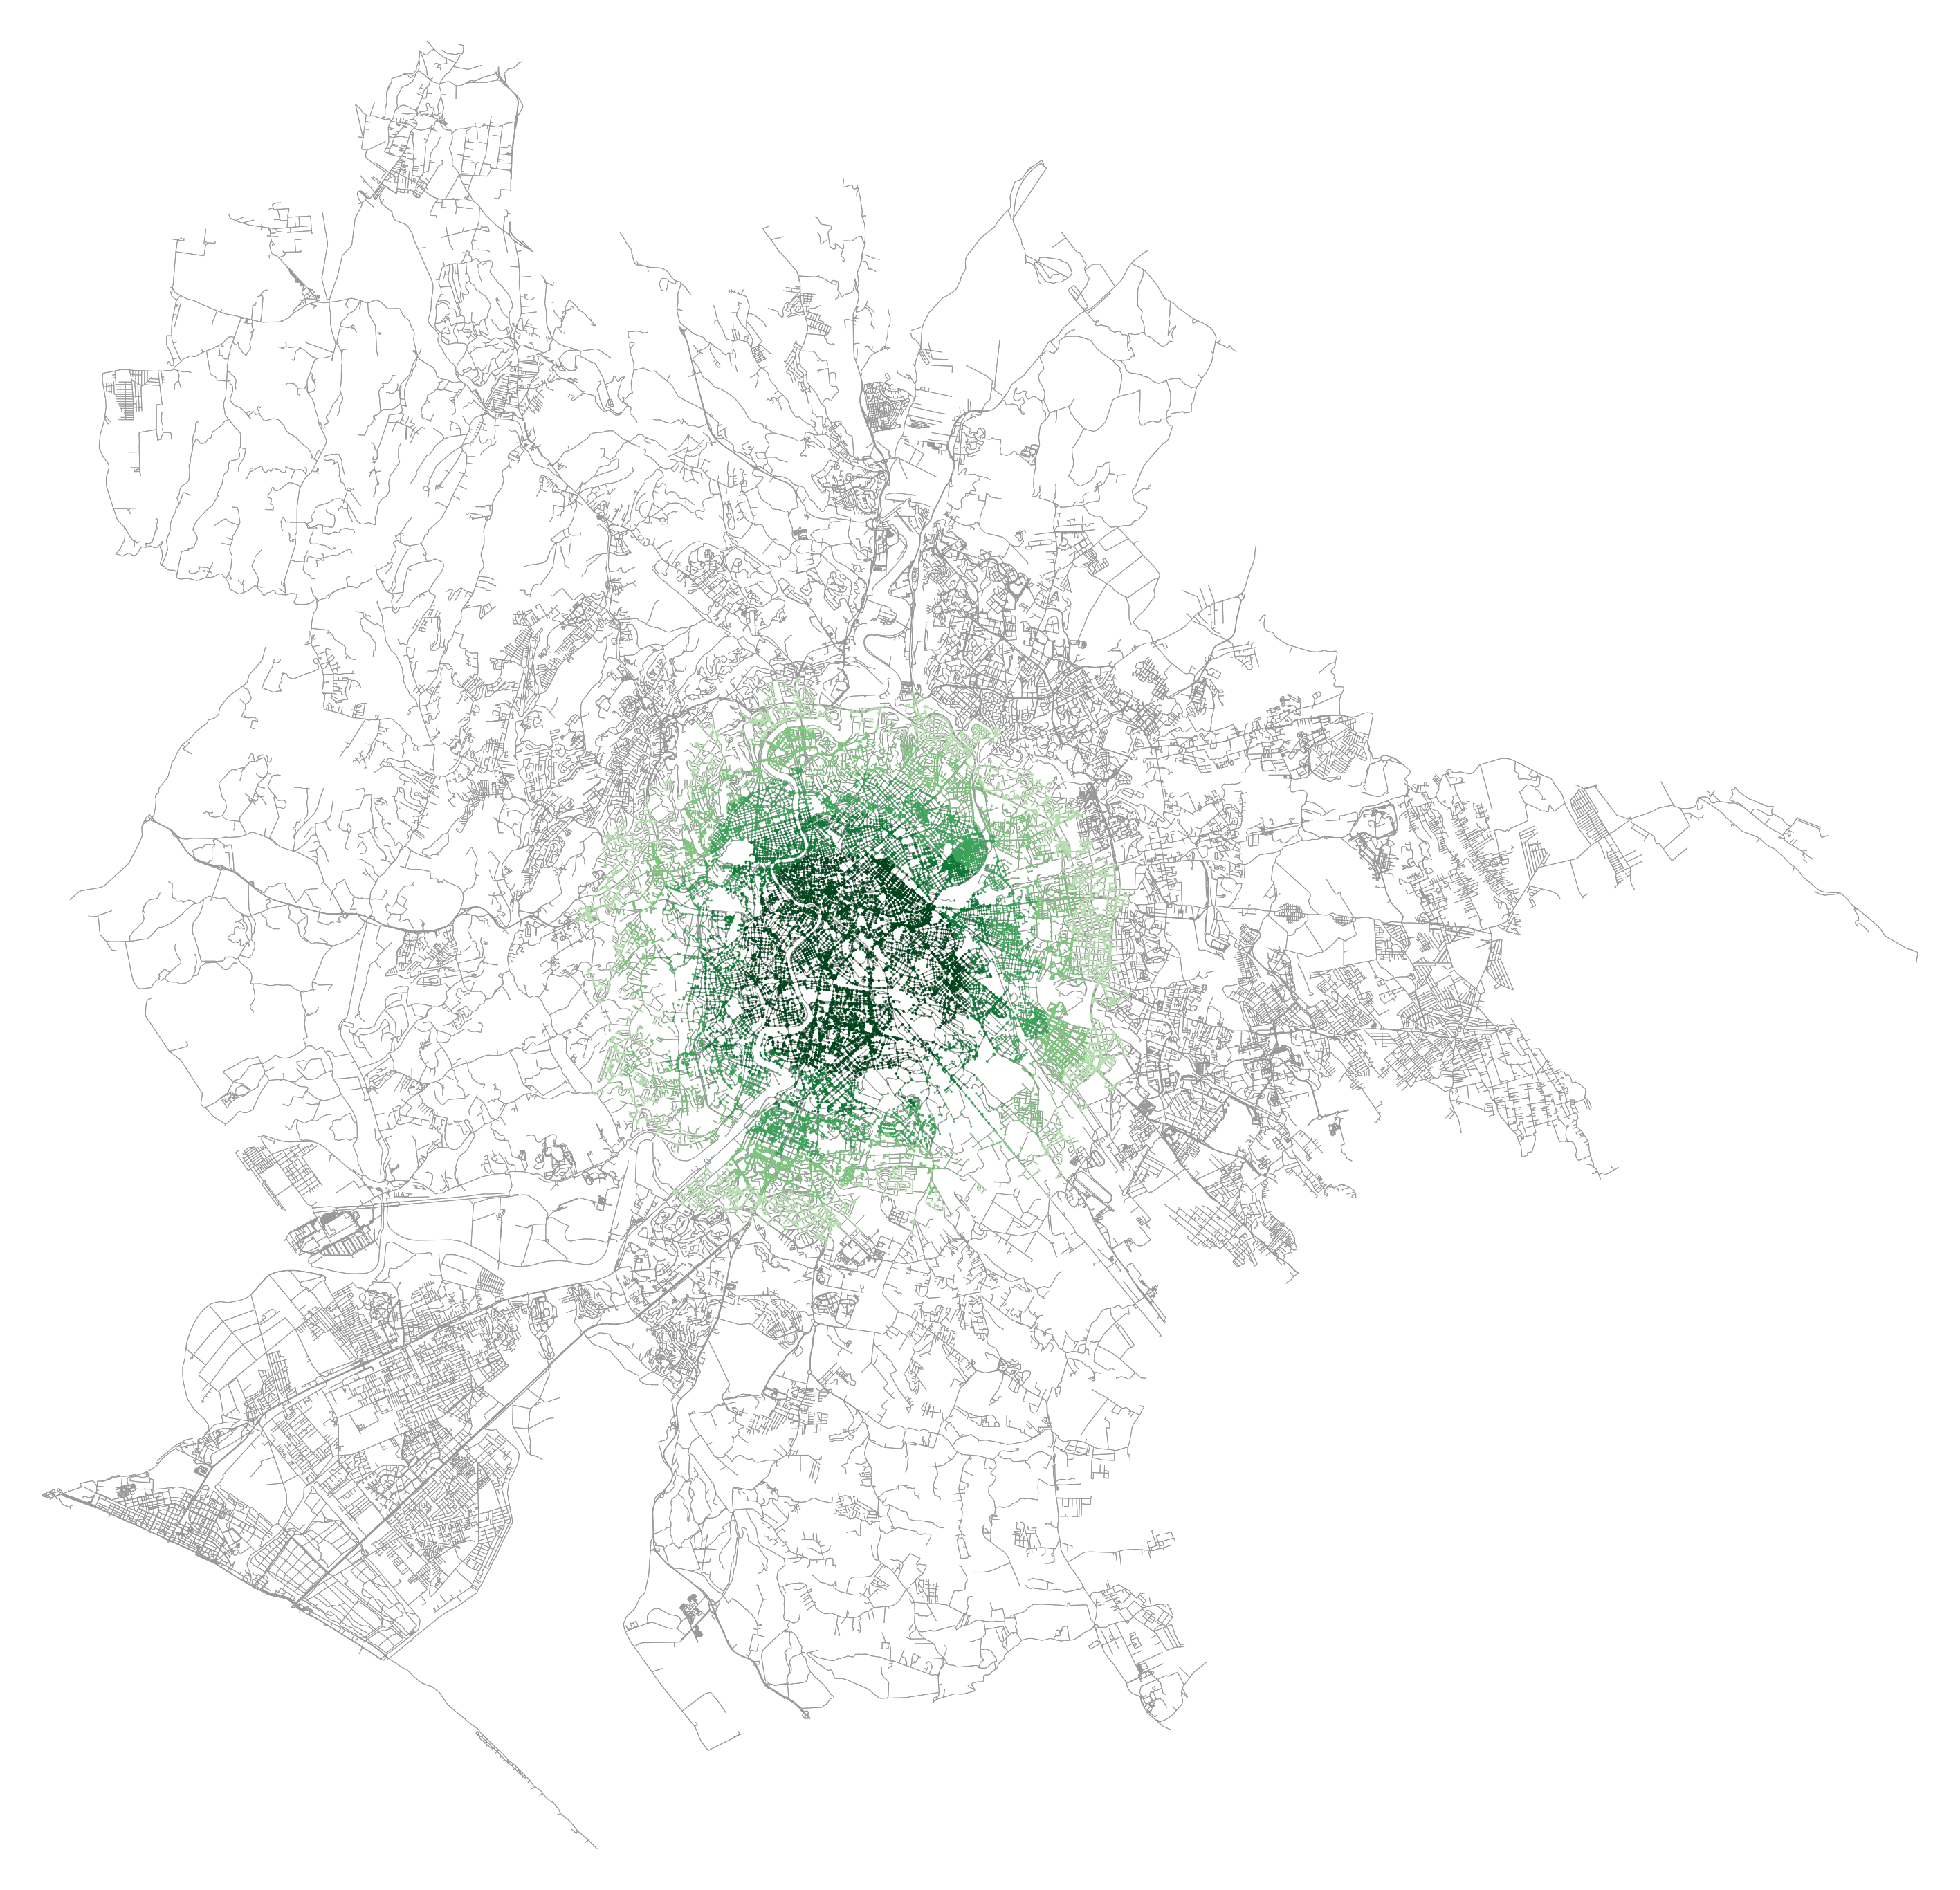

In [21]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=50, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)